In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, Binarizer, LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    ,cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

from imblearn.over_sampling import SMOTE

# Helper Functions

In [2]:
target_names=['does not smoke','smokes']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def confusion_matrices(y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title='Confusion matrix, Normalized')

In [3]:
def plot_roc_curve(fit_model, title):
    y_score=fit_model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    # Plotting the Baseline
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.grid(which='major')
    plt.title(f"{title} ROC curve")
    s= 'AUC: ' + str(round(metrics.roc_auc_score(y_test, fit_model.predict(X_test)),3))
    plt.text(0.75, 0.25, s=s, ha='right', va='bottom', fontsize=14,
             bbox=dict(facecolor='grey', alpha=0.5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');

In [4]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

# cut = np.linspace(0,1,100)
# cost = np.zeros_like(cut)
# from sklearn.model_selection import KFold, cross_val_predict
# obs = np.ravel(y)

# K = 20
# for j in range(K):
#     folds = KFold(n_splits=5,shuffle=True)
#     prob = cross_val_predict(logreg,X,np.ravel(y),cv=folds,method='predict_proba',n_jobs=5)[:,1]
#     getcost = makecost(obs,prob,falsepos_cost=20,falseneg_cost=25)
#     currentcost = getcost(cut)/X.shape[0]
#     cost += currentcost
#     plt.plot(cut, currentcost,c='C0',alpha=0.05)
# cost /= K
# plt.plot(cut,cost,c='C0')
# plt.xlabel('cutoff')
# plt.ylabel('Expected cost per data point');

# Load Data

In [10]:
cupid = pd.read_hdf('data/cupid_cleaned.hd5', key='df', mode='r')
#cupid = load_pd_pkl('data/cupid_cleaned')

In [11]:
target = ['binary_smokes']
continuous = ['age', 'height']
# bi_categorical = ['sex', 'wants_kids', 'signs_fun', 'signs_unimportant', 'signs_important',
#                      'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                      'religion_serious', ]
# mult_categorical = ['body_type', 'drinks', 'drugs', 'income', 'orientation', 'status',
#                       'diet_intensity', 'diet_choice', 'primary_ethnicity',
#                       'has_kids','likes_cats', 'likes_dogs', 'dislikes_cats', 'dislikes_dogs',
#                       'has_cats', 'has_dogs','english_fluent','english_poor','spanish_fluent',
#                       'spanish_not_poorly','religion_name','new_education',]



# remove from bi: 'signs_fun', 'signs_unimportant', 'signs_important', 'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                     'religion_serious',

bi_categorical = ['sex', 'wants_kids',
                    ]

# remove from multi:  'new_education','likes_cats', 'likes_dogs', 'dislikes_cats', 
#          'dislikes_dogs', 'has_cats', 'has_dogs', 'primary_ethnicity', , 
#          'english_fluent','english_poor','spanish_fluent','spanish_not_poorly',
#          'diet_intensity', 'diet_choice', 'religion_name'
                      
mult_categorical = ['body_type', 'income', 'orientation', 'status',
                      'has_kids', 'drinks', 'drugs',]


# Assign feature groupings
columns = bi_categorical + mult_categorical + target

# Create DF of everything
df = cupid[target + continuous + bi_categorical + mult_categorical]

### Change data type of age
df['age'] = df.age.astype(float)

df = df.dropna()

# Split DF of only standardized/scaled features
scaled_features = df.copy().loc[:, continuous]

# Tranform age and height (standardized features)
features = scaled_features[continuous]
features = StandardScaler().fit_transform(features.values)
scaled_features[continuous] = features

# Create dummy variables for original features, then combine back with scaled features
dummies = pd.get_dummies(df.loc[:, columns], columns=columns, drop_first=False)
df = scaled_features.join(dummies)

# Drop all "placeholder" columns
df.drop(df.filter(regex='placeholder'), axis=1, inplace=True)

# Drop "No" smoking column
df.drop(columns="binary_smokes_no", axis=1, inplace=True)

# SETUP MODELING DATA

X = df.drop('binary_smokes_yes', axis=1)
y = df['binary_smokes_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
df.shape

(17625, 55)

In [13]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 2262
Before OverSampling, counts of label '0': 10075 

After OverSampling, the shape of train_X: (20150, 54)
After OverSampling, the shape of train_y: (20150,) 

After OverSampling, counts of label '1': 10075
After OverSampling, counts of label '0': 10075


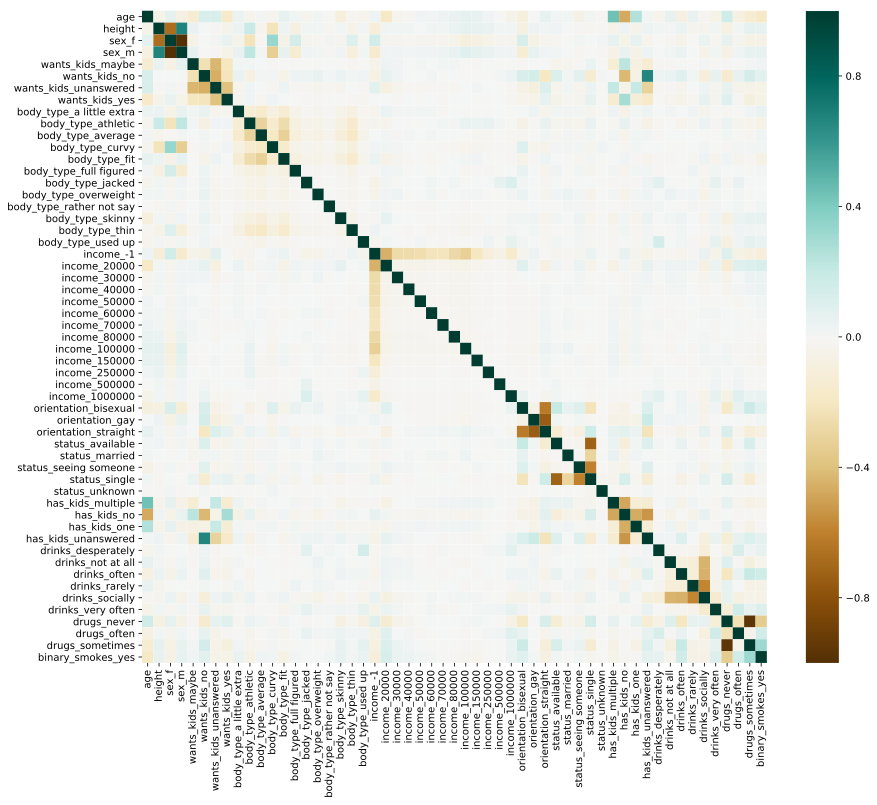

In [14]:
fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(df.corr(), xticklabels=True, cmap='BrBG');

# K-Nearest Neighbors (KNN)

## GridSearchCV

### Warning, this is quite computationally heavy! (30+ minutes)


### A few RandomizedSearchCV searches helped me narrow the range to between K = 1-8. Both uniform and distance were the best results for weight.

In [15]:
knn = KNeighborsClassifier()

# define the parameter values that should be searched
#k_range = list(range(1, 7))
#weight_options = ['uniform', 'distance']

k_range = list(range(1,13))
weight_options = ['uniform', 'distance']
#weight_options = ['uniform', 'distance']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
# print(param_grid)

# instantiate the grid
grid_knn = RandomizedSearchCV(knn, param_grid, cv=10, scoring='f1', n_jobs=-1, n_iter=15)

# fit the grid with data
grid_knn.fit(X_train, y_train)

# examine the best model
print(grid_knn.best_score_)
print(grid_knn.best_params_)
print(grid_knn.best_estimator_)

0.8532151317410714
{'weights': 'uniform', 'n_neighbors': 1}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')


In [16]:
joblib.dump(grid_knn, 'models/knn_SMOTE.joblib')  # Save model to disk

['models/knn_SMOTE.joblib']

In [17]:
y_pred_knn = grid_knn.predict(X_test)
print("test f1:", metrics.f1_score(y_test, y_pred_knn))
print("test accuracy:", metrics.accuracy_score(y_test, y_pred_knn))

test f1: 0.3651488616462347
test accuracy: 0.7257942511346445


In [18]:
print('AUC:', round(metrics.roc_auc_score(y_test, y_pred_knn),3))

AUC: 0.611


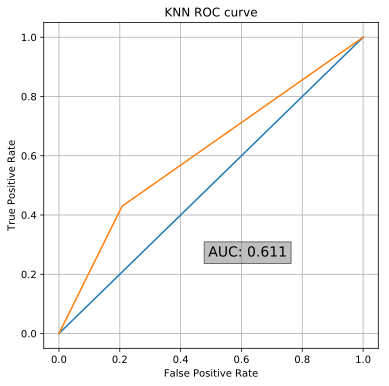

In [19]:
plot_roc_curve(grid_knn, 'KNN')

classification report: 

                precision    recall  f1-score   support

does not smoke       0.86      0.79      0.83      4318
        smokes       0.32      0.43      0.37       970

     micro avg       0.73      0.73      0.73      5288
     macro avg       0.59      0.61      0.60      5288
  weighted avg       0.76      0.73      0.74      5288

Confusion matrix, without normalization
[[3421  897]
 [ 553  417]]
Normalized confusion matrix
[[0.79 0.21]
 [0.57 0.43]]


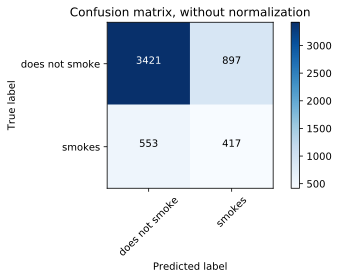

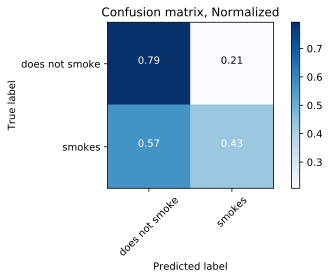

In [20]:
print("classification report: \n")
print(metrics.classification_report(y_test, y_pred_knn, target_names=['does not smoke','smokes']))
confusion_matrices(y_pred_knn)

### Now messing with THRESHOLD

In [21]:
y_prob = grid_knn.predict_proba(X_test)

y_pred_knn_prob = y_prob[:,1] >= 0.3

print(metrics.classification_report(y_test, y_pred_knn_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_knn_prob))

                precision    recall  f1-score   support

does not smoke       0.86      0.79      0.83      4318
        smokes       0.32      0.43      0.37       970

     micro avg       0.73      0.73      0.73      5288
     macro avg       0.59      0.61      0.60      5288
  weighted avg       0.76      0.73      0.74      5288

accuracy:  0.7257942511346445


Confusion matrix, without normalization
[[3421  897]
 [ 553  417]]
Normalized confusion matrix
[[0.79 0.21]
 [0.57 0.43]]


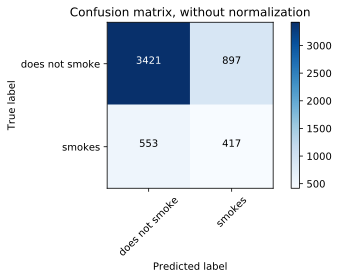

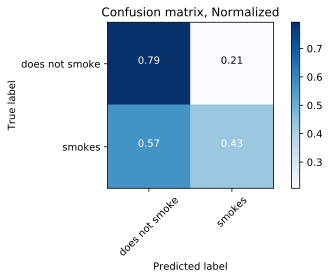

In [22]:
confusion_matrices(y_pred_knn_prob)

# Logistic Regression

In [23]:
logreg = LogisticRegression(max_iter=500, random_state=42)
# define the parameter values that should be searched
C_options = [0.5, 1, 1.5, 2, 2.5]
duals = [False]
tol_options = [1e-4, 1e-3, 1e-2]
pen_options = ['l1','l2']
solver_options = ['liblinear']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=C_options, dual=duals, tol=tol_options, penalty=pen_options, solver=solver_options)
# print(param_grid)

# instantiate the grid
grid_lr = RandomizedSearchCV(logreg, param_grid, cv=10, scoring='f1', n_jobs=-1, n_iter=20)

# fit the grid with data
grid_lr.fit(X_train, y_train);

# examine the best model
print(grid_lr.best_score_)
print(grid_lr.best_params_)
print(grid_lr.best_estimator_)

0.6864248726797924
{'tol': 0.01, 'solver': 'liblinear', 'penalty': 'l1', 'dual': False, 'C': 1.5}
LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='liblinear',
          tol=0.01, verbose=0, warm_start=False)


In [24]:
joblib.dump(grid_lr, 'models/logreg_SMOTE.joblib')  # Save model to disk

['models/logreg_SMOTE.joblib']

In [25]:
y_pred_logreg = grid_lr.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_logreg))

print(metrics.classification_report(y_test, grid_lr.predict(X_test)))


0.7413010590015129
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      4318
           1       0.38      0.64      0.47       970

   micro avg       0.74      0.74      0.74      5288
   macro avg       0.64      0.70      0.65      5288
weighted avg       0.81      0.74      0.76      5288



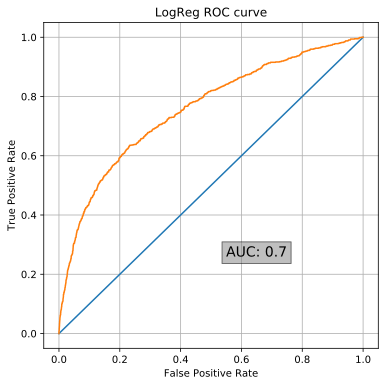

In [26]:
plot_roc_curve(grid_lr, "LogReg")

Confusion matrix, without normalization
[[3304 1014]
 [ 354  616]]
Normalized confusion matrix
[[0.77 0.23]
 [0.36 0.64]]


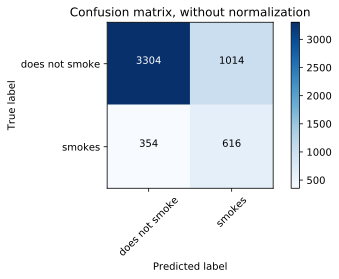

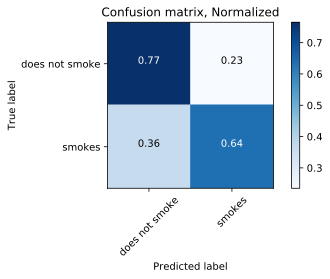

In [27]:
confusion_matrices(y_pred_logreg)

### Now messing with THRESHOLD

In [28]:
y_prob = grid_lr.predict_proba(X_test)

y_pred_lr_prob = y_prob[:,1] >= 0.25

print(metrics.classification_report(y_test, y_pred_lr_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_lr_prob))

                precision    recall  f1-score   support

does not smoke       0.94      0.27      0.42      4318
        smokes       0.22      0.92      0.36       970

     micro avg       0.39      0.39      0.39      5288
     macro avg       0.58      0.59      0.39      5288
  weighted avg       0.80      0.39      0.41      5288

accuracy:  0.39050680786686837


Confusion matrix, without normalization
[[1175 3143]
 [  80  890]]
Normalized confusion matrix
[[0.27 0.73]
 [0.08 0.92]]


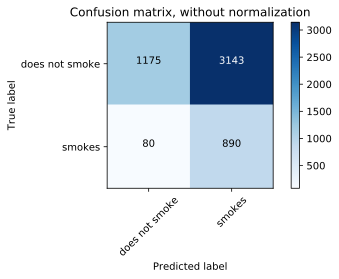

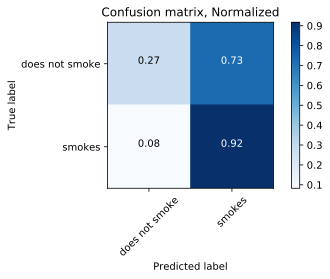

In [29]:
confusion_matrices(y_pred_lr_prob)

# Support Vector Machine (SVM)

In [77]:
svm = SVC(probability = True, random_state=42)

# Cs=[1.75]
# kernels = ['rbf']
# gammas = ['scale']
# tols = [1e-5]

Cs=[1, 1.75, 2.25]
kernels = ['rbf','sigmoid']
gammas = ['scale']
tols = [.00001, .0001]

param_grid = dict(C=Cs, tol=tols, gamma=gammas, kernel=kernels)

grid_svm = RandomizedSearchCV(svm, param_grid, cv=10, scoring='f1', n_jobs=4, n_iter=10)

grid_svm.fit(X_train, y_train)

print(grid_svm.best_score_)
print(grid_svm.best_estimator_)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/ex

0.7271863433775917
SVC(C=2.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=1e-05, verbose=False)


In [111]:
y_pred_best_svm = grid_svm.predict(X_test)

print(metrics.classification_report(y_test, y_pred_best_svm))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      4318
           1       0.46      0.51      0.49       970

   micro avg       0.80      0.80      0.80      5288
   macro avg       0.67      0.69      0.68      5288
weighted avg       0.81      0.80      0.80      5288



In [110]:
metrics.accuracy_score(y_test, y_pred_best_svm)

0.8038956127080181

In [86]:
joblib.dump(grid_svm, 'models/SVM_SMOTE.joblib')  # Save model to disk

['models/SVM_SMOTE.joblib']

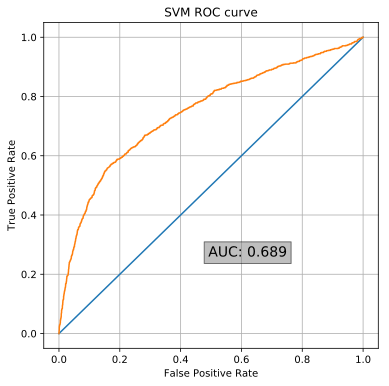

In [109]:
plot_roc_curve(grid_svm, 'SVM')

Confusion matrix, without normalization
[[3730  588]
 [ 471  499]]
Normalized confusion matrix
[[0.86 0.14]
 [0.49 0.51]]


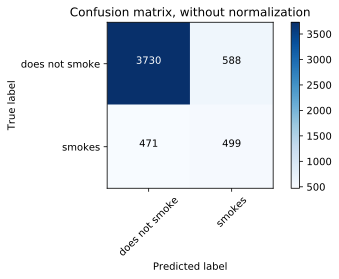

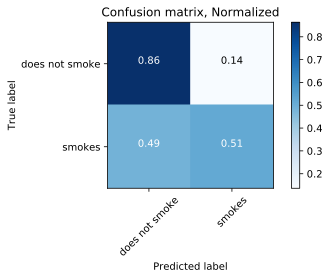

In [112]:
confusion_matrices(y_pred_best_svm)

### Now messing with THRESHOLD

In [92]:
y_prob = grid_svm.predict_proba(X_test)

y_pred_svm_prob = y_prob[:,1] > 0.144

print(metrics.classification_report(y_test, y_pred_svm_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_svm_prob))

                precision    recall  f1-score   support

does not smoke       0.92      0.11      0.20      4318
        smokes       0.19      0.96      0.32       970

     micro avg       0.26      0.26      0.26      5288
     macro avg       0.56      0.53      0.26      5288
  weighted avg       0.78      0.26      0.22      5288

accuracy:  0.2649394856278366


Confusion matrix, without normalization
[[ 474 3844]
 [  43  927]]
Normalized confusion matrix
[[0.11 0.89]
 [0.04 0.96]]


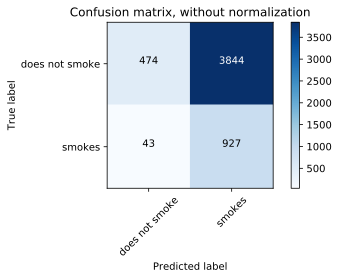

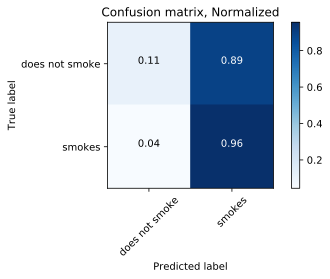

In [93]:
confusion_matrices(y_pred_svm_prob)

# Decision Trees

In [31]:
dt = DecisionTreeClassifier(random_state=42)

criterions = ['gini', 'entropy']    

param_grid = dict(criterion=criterions)

grid_dt = GridSearchCV(dt, param_grid, scoring='f1', cv=10, n_jobs=-1)

grid_dt.fit(X_train, y_train)

print(grid_dt.best_score_)
print(grid_dt.best_params_)
print(grid_dt.best_estimator_)

0.8147954388299358
{'criterion': 'gini'}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [32]:
joblib.dump(grid_dt, 'models/DecisionTree_SMOTE.joblib')  # Save model to disk

['models/DecisionTree_SMOTE.joblib']

In [33]:
y_pred_dtree = grid_dt.predict(X_test)

print(metrics.classification_report(y_test, y_pred_dtree))
print('accuracy:', metrics.accuracy_score(y_test, y_pred_dtree))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4318
           1       0.34      0.38      0.36       970

   micro avg       0.75      0.75      0.75      5288
   macro avg       0.60      0.61      0.60      5288
weighted avg       0.76      0.75      0.76      5288

accuracy: 0.7530257186081695


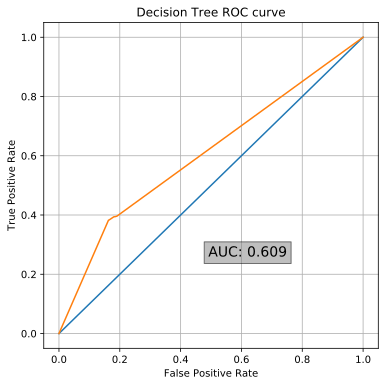

In [34]:
plot_roc_curve(grid_dt, "Decision Tree")

Confusion matrix, without normalization
[[3611  707]
 [ 599  371]]
Normalized confusion matrix
[[0.84 0.16]
 [0.62 0.38]]


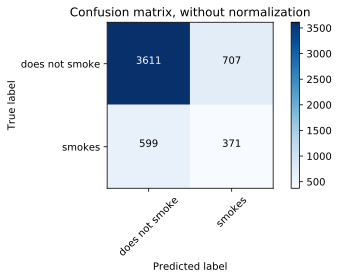

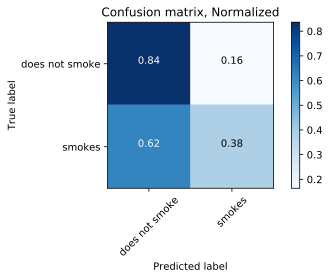

In [35]:
confusion_matrices(y_pred_dtree)

### Now messing with THRESHOLD - Nothing in Decision Tree matters.

In [36]:
y_prob = grid_dt.predict_proba(X_test)

y_pred_dt_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_dt_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_dt_prob))

                precision    recall  f1-score   support

does not smoke       0.86      0.84      0.85      4318
        smokes       0.34      0.38      0.36       970

     micro avg       0.75      0.75      0.75      5288
     macro avg       0.60      0.61      0.60      5288
  weighted avg       0.76      0.75      0.76      5288

accuracy:  0.7530257186081695


Confusion matrix, without normalization
[[3611  707]
 [ 599  371]]
Normalized confusion matrix
[[0.84 0.16]
 [0.62 0.38]]


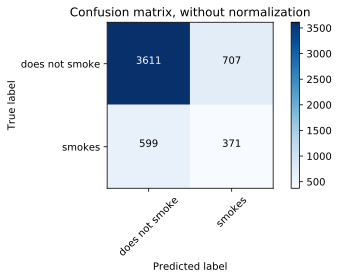

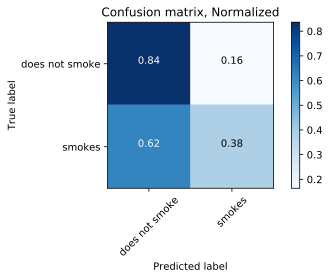

In [37]:
confusion_matrices(y_pred_dt_prob)

# Random Forrest

In [81]:
rf = RandomForestClassifier(random_state=42)

criterions = ['gini', 'entropy']
n_ests = [50, 100]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests)

grid_rf = GridSearchCV(rf, param_grid, scoring='f1', cv=10, n_jobs=4)
grid_rf.fit(X_train[11130:13130], y_train[11130:13130])

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

0.7760468831714613
{'criterion': 'entropy', 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [82]:
joblib.dump(grid_rf, 'models/RandomForest_SMOTE.joblib')  # Save model to disk

['models/RandomForest_SMOTE.joblib']

In [83]:
y_pred_rf = grid_rf.predict(X_test)

print(metrics.classification_report(y_test, y_pred_rf))
print('accuracy:', metrics.accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      4318
           1       0.38      0.49      0.43       970

   micro avg       0.76      0.76      0.76      5288
   macro avg       0.63      0.66      0.64      5288
weighted avg       0.79      0.76      0.77      5288

accuracy: 0.7598335854765507


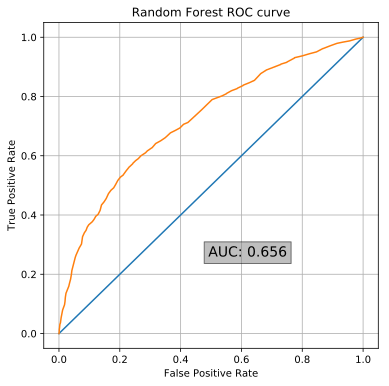

In [94]:
plot_roc_curve(grid_rf, "Random Forest")

Confusion matrix, without normalization
[[3541  777]
 [ 493  477]]
Normalized confusion matrix
[[0.82 0.18]
 [0.51 0.49]]


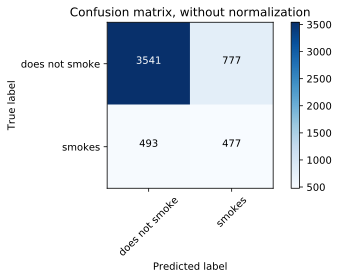

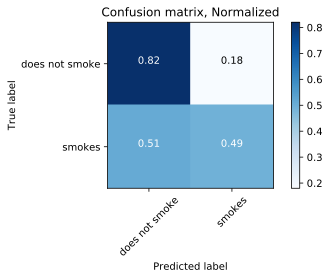

In [89]:
confusion_matrices(y_pred_rf)

### Now messing with THRESHOLD

In [90]:
y_prob = grid_rf.predict_proba(X_test)

y_pred_rf_prob = y_prob[:,1] > 0.35

print(metrics.classification_report(y_test, y_pred_rf_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_rf_prob))

                precision    recall  f1-score   support

does not smoke       0.89      0.67      0.76      4318
        smokes       0.30      0.65      0.41       970

     micro avg       0.66      0.66      0.66      5288
     macro avg       0.60      0.66      0.59      5288
  weighted avg       0.79      0.66      0.70      5288

accuracy:  0.662821482602118


Confusion matrix, without normalization
[[2874 1444]
 [ 339  631]]
Normalized confusion matrix
[[0.67 0.33]
 [0.35 0.65]]


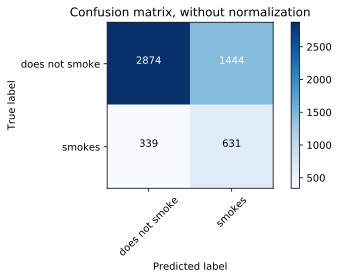

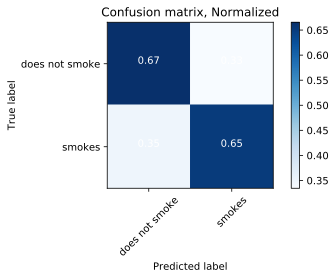

In [91]:
confusion_matrices(y_pred_rf_prob)

# Gradient Boosting

In [95]:
gb = GradientBoostingClassifier(random_state=42)

losses = ['deviance', 'exponential']
lrs = [0.1, 0.5, 1]
n_ests = [100, 200, 400]
subsamples=[0.5, 0.75, 1]
# criterions=[
# mins=[
# minl=[
maxd = [3,4,5]
tols = [.0001]
    
    

param_grid = dict(loss=losses, learning_rate=lrs, n_estimators=n_ests, subsample=subsamples,
                 max_depth=maxd, tol=tols)

grid_gb = RandomizedSearchCV(gb, param_grid, scoring='f1', cv=10, n_jobs=4, n_iter=40)

grid_gb.fit(X_train[11130:13130], y_train[11130:13130])

print(grid_gb.best_score_)
print(grid_gb.best_params_)
print(grid_gb.best_estimator_)

0.8288977314413617
{'tol': 0.0001, 'subsample': 0.5, 'n_estimators': 200, 'max_depth': 5, 'loss': 'exponential', 'learning_rate': 0.1}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [96]:
joblib.dump(grid_gb, 'models/GradientBoosting_SMOTE.joblib')  # Save model to disk

['models/GradientBoosting_SMOTE.joblib']

In [97]:
y_pred_gb = grid_gb.predict(X_test)

metrics.f1_score(y_test, y_pred_gb)

0.3967479674796748

In [98]:
print(metrics.classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4318
           1       0.42      0.38      0.40       970

   micro avg       0.79      0.79      0.79      5288
   macro avg       0.64      0.63      0.63      5288
weighted avg       0.78      0.79      0.79      5288



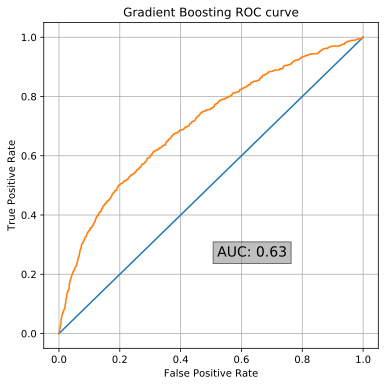

In [99]:
plot_roc_curve(grid_gb, "Gradient Boosting")

Confusion matrix, without normalization
[[3809  509]
 [ 604  366]]
Normalized confusion matrix
[[0.88 0.12]
 [0.62 0.38]]


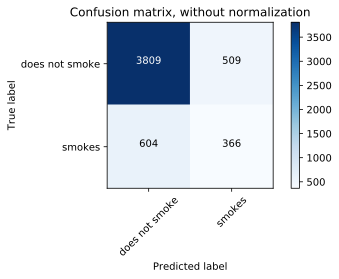

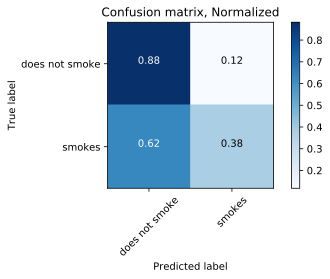

In [100]:
confusion_matrices(y_pred_gb)

### Now messing with THRESHOLD

In [101]:
y_prob = grid_gb.predict_proba(X_test)

y_pred_gb_prob = y_prob[:,1] > 0.28

print(metrics.classification_report(y_test, y_pred_gb_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_gb_prob))

                precision    recall  f1-score   support

does not smoke       0.88      0.79      0.83      4318
        smokes       0.35      0.51      0.42       970

     micro avg       0.74      0.74      0.74      5288
     macro avg       0.61      0.65      0.62      5288
  weighted avg       0.78      0.74      0.76      5288

accuracy:  0.7388426626323752


Confusion matrix, without normalization
[[3415  903]
 [ 478  492]]
Normalized confusion matrix
[[0.79 0.21]
 [0.49 0.51]]


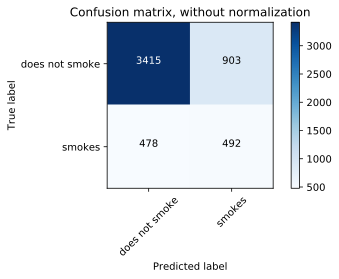

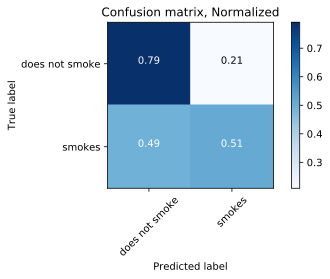

In [102]:
confusion_matrices(y_pred_gb_prob)

# Naive Bayes

In [46]:
nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [47]:
joblib.dump(nb, 'models/NaiveBayesGaussian_SMOTE.joblib')  # Save model to disk

['models/NaiveBayesGaussian_SMOTE.joblib']

In [48]:
y_pred_nb = nb.predict(X_test)

In [49]:
metrics.f1_score(y_test, y_pred_nb)

0.3335423197492163

In [50]:
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.88      0.30      0.45      4318
           1       0.21      0.82      0.33       970

   micro avg       0.40      0.40      0.40      5288
   macro avg       0.55      0.56      0.39      5288
weighted avg       0.76      0.40      0.43      5288



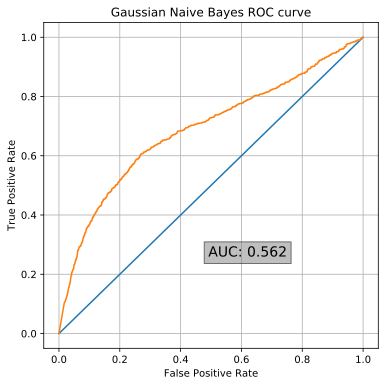

In [51]:
plot_roc_curve(nb, "Gaussian Naive Bayes")

Confusion matrix, without normalization
[[1301 3017]
 [ 172  798]]
Normalized confusion matrix
[[0.3  0.7 ]
 [0.18 0.82]]


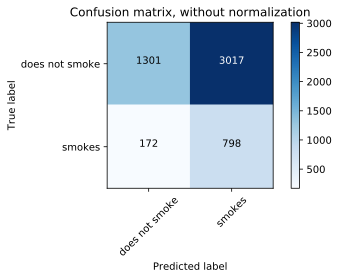

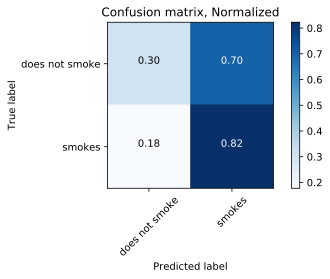

In [52]:
confusion_matrices(y_pred_nb)

### Now messing with THRESHOLD

In [53]:
y_prob = nb.predict_proba(X_test)

y_pred_nb_prob = y_prob[:,1] > 0.7

print(metrics.classification_report(y_test, y_pred_nb_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_nb_prob))

                precision    recall  f1-score   support

does not smoke       0.89      0.35      0.50      4318
        smokes       0.22      0.80      0.34       970

     micro avg       0.43      0.43      0.43      5288
     macro avg       0.55      0.58      0.42      5288
  weighted avg       0.76      0.43      0.47      5288

accuracy:  0.43116490166414523


Confusion matrix, without normalization
[[1500 2818]
 [ 190  780]]
Normalized confusion matrix
[[0.35 0.65]
 [0.2  0.8 ]]


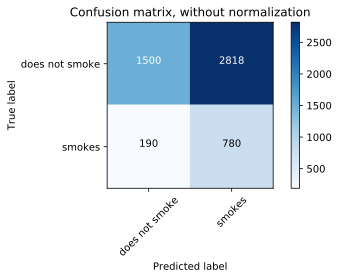

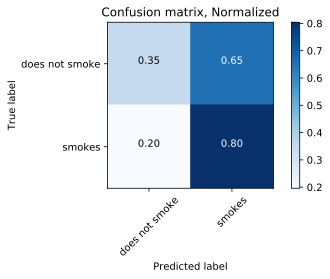

In [54]:
confusion_matrices(y_pred_nb_prob)